# Import

In [103]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import pickle

import plotly.io as pio

In [104]:
pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_white"

In [105]:
df = pd.concat([pd.read_csv('../Data/Body_Results.csv'),
            pd.read_csv('../Data/chicken_inter_final.csv'), # chickenpox cubic + nearest mrate 0.8 에서
            pd.read_csv('../Data/R_GNAR_results.csv'), # GNAR을 R에서 돌린 결과 RANDOM, BLOCK
            pd.concat([pd.read_csv('../Data/DCRNN_50_windmillsmall.csv'), # 50% windmillsmall 결과들
                       pd.read_csv('../Data/GConvGRU_50_windmillsmall.csv'),
                       pd.read_csv('../Data/GConvLSTM_50_windmillsmall.csv'),
                       pd.read_csv('../Data/LRGCN_50_windmillsmall.csv'),
                       pd.read_csv('../Data/DyGrEncoder_50_windmillsmall.csv'),
                       pd.read_csv('../Data/TGCN_50_windmillsmall.csv'),
                       pd.read_csv('../Data/GCLSTM_50_windmillsmall.csv'),
                       pd.read_csv('../Data/EvolveGCNO_50_windmillsmall.csv'),
                       pd.read_csv('../Data/EvolveGCNH_50_windmillsmall.csv'),
                      ]),
            pd.concat([pd.read_csv('../Data/DCRNN_80_windmillsmall.csv'), # 80% windmillsmall 결과들
                       pd.read_csv('../Data/LRGCN_80_windmillsmall.csv'),
                       pd.read_csv('../Data/DyGrEncoder_80_windmillsmall.csv'),
                       pd.read_csv('../Data/GConvLSTM_80_windmillsmall.csv'),
                       pd.read_csv('../Data/GConvGRU_80_windmillsmall.csv'),
                       pd.read_csv('../Data/TGCN_80_windmillsmall.csv'),
                       pd.read_csv('../Data/GCLSTM_80_windmillsmall.csv'),
                      ])
               ]).assign(model = lambda df: df.model.apply(lambda x: 'GConvGRU' if x == "GComvGRU" else x))
df = df.iloc[:,:-1]

# Conditions

| Model               | FiveVTS | Chickenpox | Pedalme | Wikimath | Windmillsmall | MontevideoBus |
|---------------------|---------|------------|---------|----------|---------------|---------------|
| Max iter.           | 30      | 30         | 30      | 30       | 30            | 30            |
| Epochs              | 50      | 50         | 50      | 50       | 50            | 50            |
| Lags                | 2       | 4          | 4       | 8        | 8             | 4             |
| Interpolation       | linear  | linear,nearest,cubic     | linear  | linear   | linear        | linear       |
| Filters             |         |            |         |          |               |               |
| GConvGRU            | 12      | 16         | 12      | 12       | 12            | 12            |
| GConvLSTM           | 12      | 32         | 2       | 64       | 16            | 12            |
| GCLSTM              | 4       | 16         | 4       | 64       | 16            | 12            |
| LRGCN               | 4       | 8          | 8       | 32       | 12            | 2             |
| DyGrEncoder         | 12      | 12         | 12      | 12       | 12            | 12            |
| EvolveGCNH          | No need | No need    | No need | No need  | No need       | No need       |
| EvolveGCNO          | No need | No need    | No need | No need  | No need       | No need       |
| TGCN                | 12      | 12         | 12      | 12       | 12            | 8             |
| DCRNN               | 2       | 16         | 8       | 12       | 4             | 12            |


# Data & 사용자정의함수

In [106]:
df_dataset = pd.DataFrame({
    'dataset':['fivenodes','chickenpox','pedalme','wikimath','windmillsmall','monte'],
    'node':[5,20,15,1068,11,675],
    'time':[200,522,36,731,17472,744]
})
df = df\
.merge(df_dataset)\
.assign(method = lambda df: df['method'].map({'STGCN':'STGNN','IT-STGCN':'IT-STGNN','GNAR':'GNAR'}))

In [107]:
df.head()

,dataset,method,mrate,mtype,lags,nof_filters,inter_method,epoch,mse,calculation_time,model,node,time
0,fivenodes,STGNN,0.0,NaN,2,12.0,NaN,50.0,0.729374,80.985221,GConvGRU,5,200
1,fivenodes,STGNN,0.0,NaN,2,12.0,NaN,50.0,0.729082,80.891788,GConvGRU,5,200
2,fivenodes,IT-STGNN,0.0,NaN,2,12.0,NaN,50.0,0.731600,114.492592,GConvGRU,5,200
3,fivenodes,IT-STGNN,0.0,NaN,2,12.0,NaN,50.0,0.735026,115.544274,GConvGRU,5,200
4,fivenodes,STGNN,0.0,NaN,2,12.0,NaN,50.0,0.727182,102.783140,GConvGRU,5,200


In [28]:
# df2 = pd.read_csv('../Data/Appendix_Results.csv').iloc[:,1:]

In [ ]:
df.assign(model = lambda df: df.model.apply(lambda x: '' if x == "GNAR" else x))\
.eval('model = method+model')

In [ ]:
df2 = df.assign(model = lambda df: df.model.apply(lambda x: '' if x == "GNAR" else x))\
.eval('model = method+model')\
.assign(model = lambda df: df.model.str.replace("STGNN",""))
df2.head()

In [64]:
set(df.method)

{'IT-STGNN', 'STGNN'}

In [108]:
df2 = df.assign(model = lambda df: df.model.apply(lambda x: '' if x == "GNAR" else x))

In [109]:
def show_experiment_spec(df):
    df_cols = ['method','mrate','mtype','lags','nof_filters','inter_method','epoch','model']
    for dataset in df.dataset.unique():
        print(f'dataset: {dataset}')
        for col in df_cols: 
            df_query = df[df['dataset'] == dataset]
            print(f'{col}: {df_query[col].unique().tolist()}')
        print('---')

`-` 데이터세트별 실험셋팅 

In [110]:
show_experiment_spec(df)

dataset: fivenodes
method: ['STGNN', 'IT-STGNN']
mrate: [0.0, 0.7, 0.8, 0.3, 0.5, 0.6, 0.125]
mtype: [nan, 'rand', 'block']
lags: [2]
nof_filters: [12.0, 4.0, 2.0]
inter_method: [nan, 'linear']
epoch: [50.0]
model: ['GConvGRU', 'GConvLSTM', 'GCLSTM', 'DCRNN', 'LRGCN', 'TGCN', 'EvolveGCNO', 'DyGrEncoder', 'EvolveGCNH']
---
dataset: chickenpox
method: ['STGNN', 'IT-STGNN']
mrate: [0.0, 0.3, 0.8, 0.5, 0.6, 0.2877697841726618]
mtype: [nan, 'rand', 'block']
lags: [4]
nof_filters: [16.0, 32.0, 8.0, 12.0]
inter_method: [nan, 'linear', 'cubic', 'nearest']
epoch: [50.0]
model: ['GConvGRU', 'GConvLSTM', 'GCLSTM', 'DCRNN', 'LRGCN', 'TGCN', 'EvolveGCNO', 'DyGrEncoder', 'EvolveGCNH']
---
dataset: pedalme
method: ['STGNN', 'IT-STGNN']
mrate: [0.0, 0.3, 0.5, 0.6, 0.8, 0.2857142857142857]
mtype: [nan, 'rand', 'block']
lags: [4]
nof_filters: [12.0, 2.0, 4.0, 8.0]
inter_method: [nan, 'linear']
epoch: [50.0]
model: ['GConvGRU', 'GConvLSTM', 'GCLSTM', 'DCRNN', 'LRGCN', 'TGCN', 'EvolveGCNO', 'DyGrEncoder',

`-` 요약 

In [111]:
df_summary = df2.groupby(["method","dataset","mrate","model"]).agg({'mse':'mean'}).reset_index()\
.pivot_table(index=['model'],columns=['dataset'],values='mse')
df_summary

dataset,chickenpox,fivenodes,monte,pedalme,wikimath,windmillsmall
model,,,,,,
DCRNN,1.186396,1.245254,1.040303,1.315441,0.629504,1.121333
DyGrEncoder,1.230307,1.268549,1.189316,1.313140,0.594728,1.209075
EvolveGCNH,1.068355,1.191876,1.634331,1.256039,0.807636,1.078108
EvolveGCNO,1.079361,1.181221,1.818289,1.270238,0.756906,1.106292
GCLSTM,1.226473,1.229599,1.021227,1.265733,0.761064,1.174773
GConvGRU,1.436439,1.294271,1.064923,1.496929,0.587541,1.245208
GConvLSTM,1.329921,1.252394,1.011046,1.259794,0.813429,1.200515
LRGCN,1.142547,1.231416,0.982733,1.291406,0.721472,1.147056
TGCN,1.164413,1.119728,1.060148,1.281458,0.754307,1.108685


In [112]:
df_summary = df2.groupby(["method","dataset","mrate","model"]).agg({'mse':'mean'}).reset_index()\
.pivot_table(index=['model','method'],columns=['dataset'],values='mse')
df_summary

dataset               chickenpox  fivenodes     monte   pedalme  wikimath  \
model       method                                                          
DCRNN       IT-STGNN    0.973239   1.237063  0.989507  1.257928  0.601082   
            STGNN       1.399553   1.253446  1.091098  1.372954  0.657926   
DyGrEncoder IT-STGNN    1.033385   1.192339  1.089981  1.270727  0.573470   
            STGNN       1.427229   1.344759  1.288651  1.355552  0.615986   
EvolveGCNH  IT-STGNN    1.041603   1.188203  1.530757  1.248588  0.799767   
            STGNN       1.095108   1.195548  1.737905  1.263490  0.815505   
EvolveGCNO  IT-STGNN    1.042245   1.176323  1.628969  1.262417  0.745595   
            STGNN       1.116477   1.186119  2.007608  1.278059  0.768218   
GCLSTM      IT-STGNN    1.020271   1.219957  0.984011  1.230769  0.667062   
            STGNN       1.432674   1.239241  1.058442  1.300697  0.855066   
GConvGRU    IT-STGNN    1.082791   1.161540  0.980661  1.432194  0.547157   
            STGNN       1.790088   1.427002  1.149185  1.561664  0.627924   
GConvLSTM   IT-STGNN    1.067433   1.197745  0.976181  1.245974  0.700808   
            STGNN       1.592409   1.307044  1.045911  1.273614  0.926050   
LRGCN       IT-STGNN    1.002685   1.224613  0.982096  1.247820  0.645970   
            STGNN       1.282408   1.238219  0.983369  1.334992  0.796974   
TGCN        IT-STGNN    1.098706   1.105367  1.013108  1.277836  0.747570   
            STGNN       1.230120   1.134089  1.107188  1.285080  0.761045   

dataset               windmillsmall  
model       method                   
DCRNN       IT-STGNN       1.054938  
            STGNN          1.187728  
DyGrEncoder IT-STGNN       1.068568  
            STGNN          1.349583  
EvolveGCNH  IT-STGNN       1.025276  
            STGNN          1.130941  
EvolveGCNO  IT-STGNN       1.027922  
            STGNN          1.184662  
GCLSTM      IT-STGNN       1.057227  
            STGNN          1.292318  
GConvGRU    IT-STGNN       1.108584  
            STGNN          1.381831  
GConvLSTM   IT-STGNN       1.080793  
            STGNN          1.320238  
LRGCN       IT-STGNN       1.053308  
            STGNN          1.240803  
TGCN        IT-STGNN       1.036137  
            STGNN          1.181232

# 시각화1: MissingRate (본문)

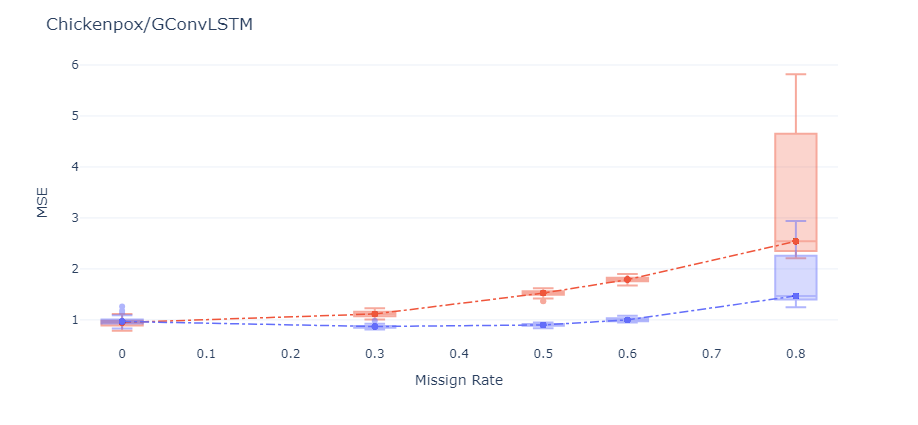

In [113]:
big = df.query("mtype=='rand' or mtype.isna()").query("dataset == 'chickenpox'").query("model == 'GConvLSTM'")\
.sort_values(by='mrate')\
.assign(mrate_jittered = lambda df: np.array(df['mrate'])+np.random.randn(len(df['mrate']))*0.01)
small = big.groupby(["dataset","mrate","method"]).agg({'mse':np.median}).reset_index().rename({'mse':'mse_median'},axis=1)
tidydata = big.merge(small)
#---#
fig = px.scatter(
    tidydata,
    y='mse_median',
    x='mrate',
    opacity=0.3,
    color='method',
    width=425,
    height=425,
    hover_data='mrate',
)
fig.data[0]['mode']='markers+lines'
fig.data[0]['marker']['size'] = 6
fig.data[0]['line']['width'] = 1.5
fig.data[0]['line']['dash'] = 'dashdot'
fig.data[1]['mode']='markers+lines'
fig.data[1]['marker']['size'] = 6
fig.data[1]['line']['width'] =1.5
fig.data[1]['line']['dash'] = 'dashdot'
fig.data[0].marker.color='#EF553B'
fig.data[1].marker.color='#636efa'
box1 = px.box(
    tidydata.query("method=='STGNN'"),
    y='mse',
    x='mrate',
)
box1.data[0]['opacity']=0.5
box1.data[0]['marker']['color']='#EF553B'
box2 = px.box(
    tidydata.query("method=='IT-STGNN'"),
    y='mse',
    x='mrate',
)
box2.data[0]['opacity']=0.5
box2.data[0]['marker']['color']='#636efa'
fig.add_traces(box1.data)
fig.add_traces(box2.data)
fig.data[0]['showlegend'] =False
fig.data[1]['showlegend'] =False
fig.layout['xaxis']['title']['text']='Missign Rate'
fig.layout['yaxis']['title']['text']='MSE'
fig.layout['legend']['title']['text']=""
fig.layout['title']['text']='Chickenpox/GConvLSTM'
fig

# 시각화2: MissingRate (부록)

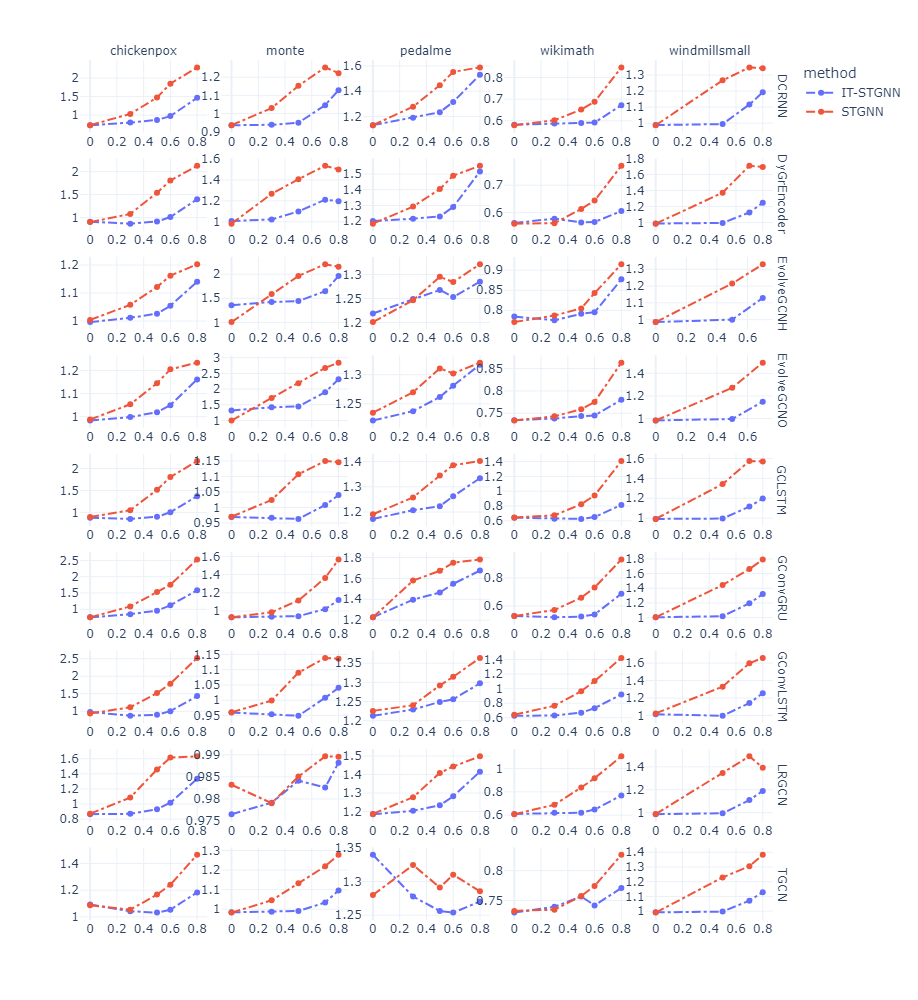

In [114]:
tidydata = df.query("mtype!='block'").query("method!='GNAR'").query("dataset != 'fivenodes' and inter_method not in ('cubic','nearest')")\
.groupby(["method","dataset","mrate","model"]).agg({'mse':'mean'}).reset_index()
#---#
fig = px.line(
    tidydata,
    x='mrate',
    y='mse',
    color='method',
    facet_row='model',
    facet_col='dataset',
    width=850,
    height=1000,
    
)
for scatter in fig.data:
    scatter['mode'] = 'lines+markers'
    scatter['line']['dash'] = 'dashdot'
for annotation in fig.layout['annotations']:
    annotation['text'] = annotation['text'].replace('dataset=','')
    annotation['text'] = annotation['text'].replace('model=','')
for k in [k for k in fig.layout if 'xaxis' in k]:
    fig.layout[k]['title']['text'] = None 
for k in [k for k in fig.layout if 'yaxis' in k]:
    fig.layout[k]['title']['text'] = None 
fig.update_yaxes(showticklabels=True,matches=None)
fig.update_xaxes(showticklabels=True,matches=None)

# 시각화3 

In [115]:
def func(x):
    if 'IT-STGCN' in x:
        return 'IT-STGNN'
    elif 'GNAR' in x:
        return 'GNAR'
    else: 
        return 'STGNN'

<ipython-input-116-631074ed5d9e>:3: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



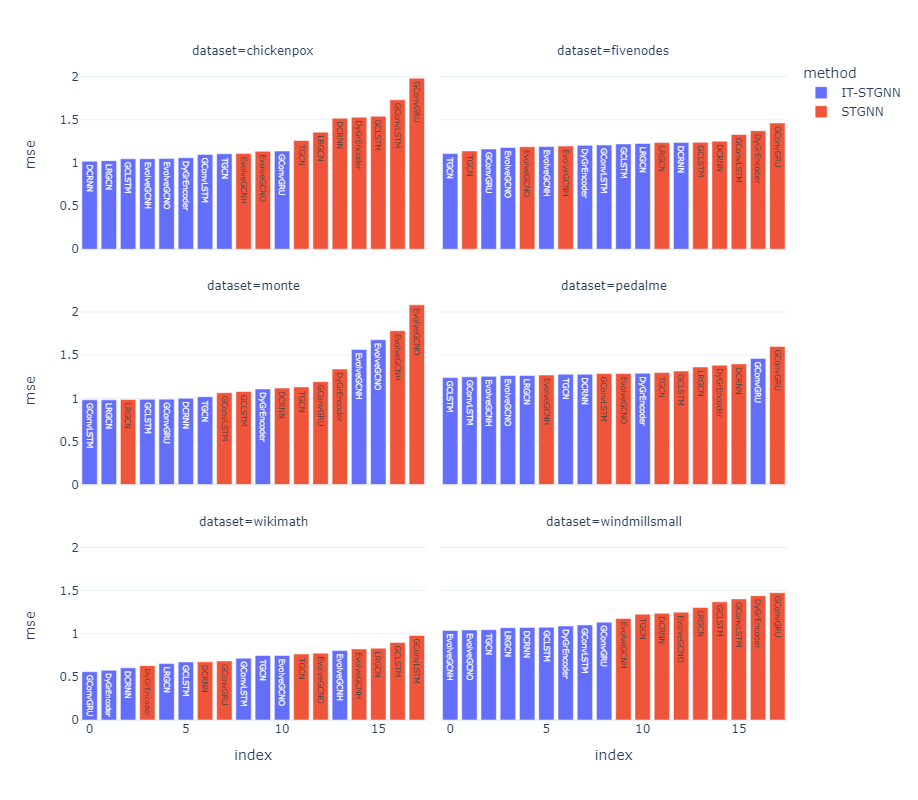

In [116]:
tidydata = df2.query('mtype != "block"').query('method!="GNAR"').groupby(["method","dataset","mrate","model"]).agg({'mse':'mean'}).reset_index()\
.pivot_table(index=['model','method'],columns=['dataset'],values='mse').stack().reset_index().rename({0:'mse'},axis=1)
tidydata = pd.concat([df.sort_values('mse').reset_index(drop=True).reset_index() for _,df in tidydata.groupby(["dataset"])])
#---#
fig = px.bar(
    tidydata,
    x='index',
    y='mse',
    color='method',
    facet_col='dataset',
    facet_col_wrap=2,
    text='model',
    height=800
)
fig

# 시각화4

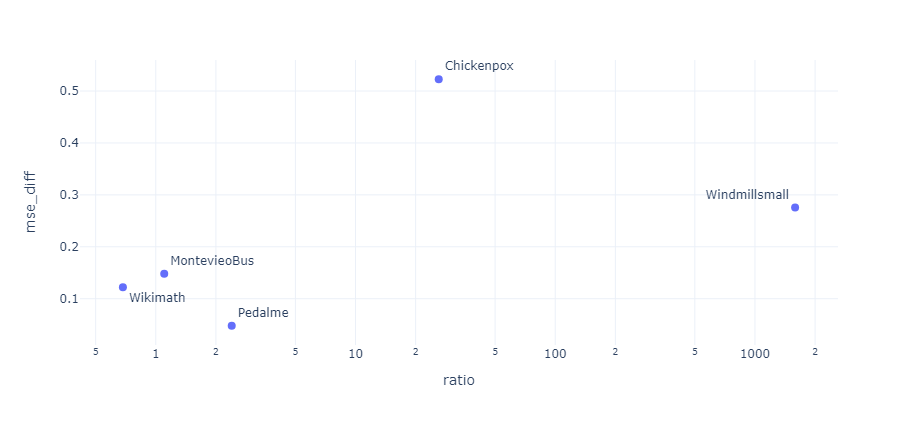

In [117]:
tidydata = df.query('mtype != "block"').query('dataset != "fivenodes"')\
.groupby(["method","dataset","node","time"]).agg({'mse':'mean'}).reset_index()\
.assign(ratio = lambda df: df['time']/df['node'])\
.pivot_table(index=['dataset','ratio'] ,columns=['method'],values='mse')\
.assign(mse_diff = lambda df: df['STGNN']- df['IT-STGNN']).loc[:,'mse_diff']\
.reset_index()
tidydata
fig = px.scatter(
    tidydata,
    x='ratio',
    log_x=True,
    y='mse_diff',
    text='dataset',
    width=625,
    height=425,
)
fig.data[0]['textposition'] = ['top right']*3 + ['bottom right'] + ['top left']
fig.data[0]['marker']['size'] = 8
fig.data[0].text = ['Chickenpox', 'MontevieoBus', 'Pedalme', 'Wikimath', 'Windmillsmall']
fig

# 시각화5

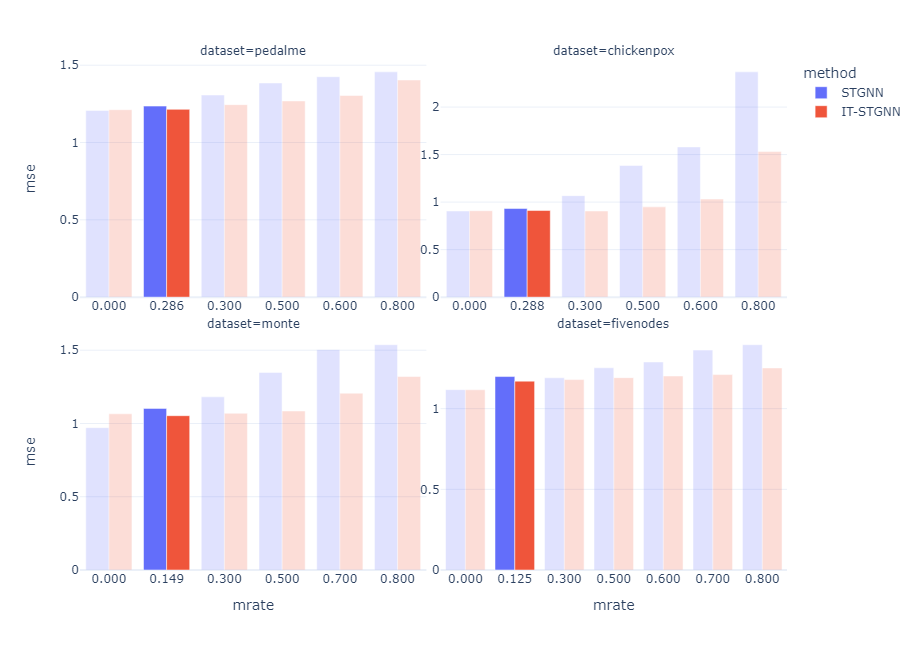

In [118]:
tidydata = df.assign(mtype = df['mtype'].fillna("rand"))\
.query('method != "GNAR"').query('dataset != "windmillsmall"').query('dataset != "wikimath"')\
.groupby(["method","dataset","mtype","mrate"]).agg({'mse':'mean'}).reset_index()\
.sort_values('mrate')\
.assign(mrate = lambda df: df['mrate'].apply(lambda x: f'{x:.3f}'))
#---#
fig = px.bar(
    tidydata,
    x='mrate',
    y='mse',
    color='method',
    facet_col='dataset',
    facet_col_wrap=2,    
    width=850,
    height=650,
    barmode='group',
    hover_data='mtype',
    opacity=0.2
)
fig.update_yaxes(showticklabels=True,matches=None)
fig.update_xaxes(showticklabels=True,matches=None) 
for trace in fig.data:
    trace['marker']['opacity']=[0.2, 1, 0.2, 0.2, 0.2, 0.2, 0.2]
fig